# Импорт библиотек 

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

# Просмотр общей информации 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
display(data.head())
print()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


# Анализ данных

Минимальная дата: 2018-03-04 00:00:00
Максимальная дата: 2018-09-02 00:00:00
Хролонология: True


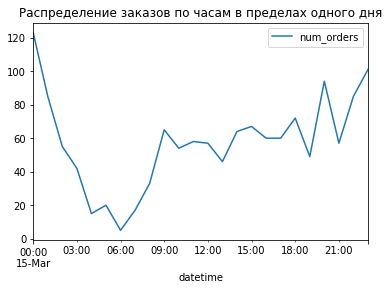

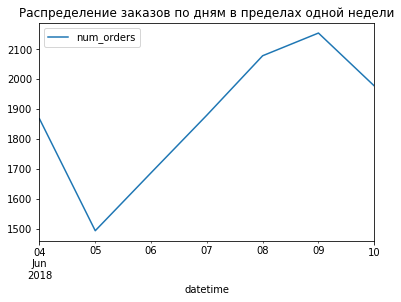

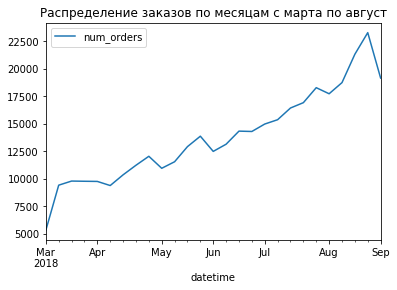

In [3]:
data_1 = data.copy()
data_1 = data_1.resample('1H').sum()
data_1['2018-03-15'].plot()
plt.title('Распределение заказов по часам в пределах одного дня')

data_1 = data_1.resample('1D').sum()
data_1['2018-06-04':'2018-06-10'].plot()
plt.title('Распределение заказов по дням в пределах одной недели')

data_1 = data_1.resample('1W').sum()
data_1.plot()
plt.title('Распределение заказов по месяцам с марта по август')


print('Минимальная дата:', data_1.index.min())
print('Максимальная дата:', data_1.index.max())
print('Хролонология:', data_1.index.is_monotonic)



Text(0.5, 1.0, 'All data')

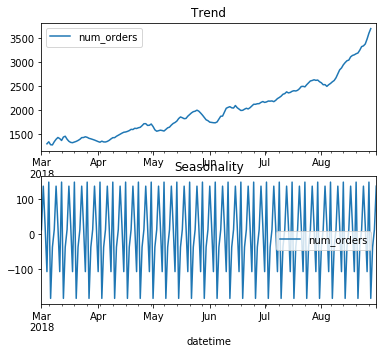

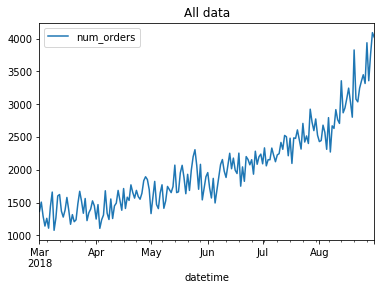

In [4]:
data_graph = data.copy()
data_graph = data_graph.resample('1D').sum()
decomposed = seasonal_decompose(data_graph)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

data_graph.plot()
plt.title('All data')


## Вывод: 
**Имеем дынные без пропусков, с 1 марта по 31 августа 2018 года. Распределение заказов в пределах одного дня имееет пиковое значение в полночь, далее падает до 6 утра, затем снова начинает возрастать до 9 утра, далее держится примерно на одном уровне до 18 вечера и снова возрастает к полуночи. Распределение заказов в пределах одной недели имеет пиковую нагрузку в пятницу и субботу и минимальную во вторник. В данных присутствует тренд - постоянный рост количества заказов, также была выявлена сезонность - циклично повторяющаяся закономерность по всему ряду (в данном случае каждую неделю).**

# Предобработка данных

In [5]:
data = data.resample('1H').sum()

def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new
    
data_new = make_features(data, 7, 7)
data_new = data_new.dropna()
display(data_new)

train, test = train_test_split(data_new, shuffle=False, test_size=0.1)



,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,42.571429
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,35.285714
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,35.000000
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,34.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.428571
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,165.714286


# Обучение моделей 

## LGBMRegressor 

In [6]:
n_estimators = [10, 50, 100, 200, 300]
max_depth = [2, 4, 6, 8, 10]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]

hyperparameter_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'learning_rate': learning_rate}

model = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=5)

random_cv = RandomizedSearchCV(estimator=model,
        param_distributions=hyperparameter_grid,
        cv=tscv, n_iter=40,
        scoring = 'neg_mean_squared_error', verbose = 0,
        random_state=42)

features = train.drop(['num_orders'], axis = 1)
target = train['num_orders']
random_cv.fit(features, target)
print("Лучшие параметры: {}".format(random_cv.best_params_))


Лучшие параметры: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1}


In [7]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

model = LGBMRegressor(n_estimators = 50, max_depth = 10, learning_rate = 0.1)
model.fit(features_train, target_train)
prediction = model.predict(features_test)
score = mean_squared_error(target_test, prediction)
print('RMSE_test =', score**0.5)



RMSE_test = 44.53092906514235


## CatBoostRegressor 

In [8]:
n_estimators = [10, 50, 100, 200, 300]
max_depth = [2, 4, 6, 8, 10]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]

hyperparameter_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'learning_rate': learning_rate}

model = CatBoostRegressor(verbose = False)
tscv = TimeSeriesSplit(n_splits=5)

random_cv = RandomizedSearchCV(estimator=model,
        param_distributions=hyperparameter_grid,
        cv=tscv, n_iter=40,
        scoring = 'neg_mean_squared_error', verbose = 0,
        random_state=42)

features = train.drop(['num_orders'], axis = 1)
target = train['num_orders']
random_cv.fit(features, target)
print("Лучшие параметры: {}".format(random_cv.best_params_))

Лучшие параметры: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1}


In [9]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

model = CatBoostRegressor(n_estimators = 300, max_depth = 6, learning_rate = 0.1, verbose = False)
model.fit(features_train, target_train)
prediction = model.predict(features_test)
score = mean_squared_error(target_test, prediction)
print('RMSE_test =', score**0.5)

RMSE_test = 42.29439058019204


## LinearRegression 

In [13]:
warnings.filterwarnings('ignore')

best_score = 99999
for i in range(1, 30, 1):
    for j in range(1, 30, 1):
        
        data_new = make_features(data, i, j)
        data_new = data_new.dropna()
        train, test = train_test_split(data_new, shuffle=False, test_size=0.1)

        features = train.drop(['num_orders'], axis = 1)
        target = train['num_orders']

        features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, shuffle=False, test_size=0.25) 

        numeric = features.columns
        scaler = StandardScaler()
        scaler.fit(features_train[numeric]) 
        
        features_train[numeric] = scaler.transform(features_train[numeric])
        features_valid[numeric] = scaler.transform(features_valid[numeric])

        model = LinearRegression()
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        score = mean_squared_error(target_valid, prediction)
        if score < best_score:
            best_score = score
            best_i = i
            best_j = j
            
print('Лучший результат RMSE =', best_score**0.5, 'lag =', best_i, 'rolling =', best_j)



Лучший результат RMSE = 32.04648848878146 lag = 24 rolling = 20


In [11]:
data_new = make_features(data, 24, 20)
data_new = data_new.dropna()
display(data_new.head())
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
        
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

model = LinearRegression()
model.fit(features_train, target_train)
prediction = model.predict(features_test)
score = mean_squared_error(target_test, prediction)
print('RMSE_test =', score**0.5)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.90
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,53.25
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,58.95
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,62.10
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.55


RMSE_test = 45.82630534014252


# Общий вывод 

**В данном проекте были обучены три модели: LGBMRegressor, CatBoostRegressor, LinearRegression. Данные предобрабатывались следующим образом: были выделены в отдельные признаки месяц, день, день недели, час, скользящее среднее, а также семь "смещенных признаков". Для линейной регрессии дополнительно была проделана нормализация через StandardScaler. Гиперпараметры (количество деревьев, глубина дерева, скорость обучения) для бустинговых моделей были найдены при помощи RandomizedSearchCV. Результаты работы трех моделей представлены в таблице ниже.**

In [12]:
final_result = pd.DataFrame({'RMSE' : ['44.53', '42.29', '45,83']})
final_result.index = ['LGBMRegressor', 'CatBoostRegressor', 'LinearRegression']
display(final_result)

,RMSE
LGBMRegressor,44.53
CatBoostRegressor,42.29
LinearRegression,"45,83"
